In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Quantum kernel calculation

## Introduction

In earlier modules of this course, we introduced kernel functions with classical machine learning models. We will provide a brief recap of that definition and then extend it to the quantum domain.

A kernel in supervised and unsupervised machine learning is a function that computes the inner product between two vectors in the feature space. These vectors are derived from the original vectors in a Euclidean space by a mapping function that can be nonlinear. The feature space is usually a higher-dimensional space than the original data space. Kernel functions are used in model training and inference to substitute the explicit evaluation of the feature-mapping functions (this is known as the “kernel trick”).

In quantum computing, we define a quantum kernel as the Hilbert-Schmidt inner product between two feature vectors $\rho (x)$, $\rho (y)$ as: 

$$K(x,y) = tr[\rho (x) \rho (y)] = {\vert \langle \phi (y) \vert \phi (x) \rangle \vert}^{2}.$$  

Here, $\vert \phi (x) \rangle = U(x) \vert 0 \rangle$ with some unitary $U(x)$ and $\rho = \vert \phi \rangle \langle \phi \vert = U \vert 0 \rangle \langle 0 \vert {U}^{\dagger}$ (we assume pure states for simplicity).<sup>1</sup><sup>, </sup><sup>2</sup>

A number of different kernels can be constructed. The main challenges are: 
- Selection of a kernel that can be efficiently calculated on a quantum computer while being difficult to simulate classically.
- Identification of important real-world problems with data structures that allow such quantum kernels to be effectively applied.

There are two primary methods for calculating a quantum kernel: the transition amplitude method and the SWAP test.

In the following content, we will implement a low-level function to calculate fidelity based on the transition amplitude, and then we will use an available out-of-the-box `state_fidelity` function. Next, we will implement a circuit for the SWAP test approach for calculating fidelities. Finally, we will compare the results to the `QuantumKernel` function in the `qiskit_machine_learning` library. We will compare results from statevector and QASM simulators, where appropriate.


## Transition amplitude

The inner product between two feature vectors $\rho (x)$, $\rho (y)$ is also a special case of fidelity when both represent pure quantum states. We can rewrite the above definition of the quantum kernel as follows:

$$K(x,y) = {\vert \langle 0 \vert {U}^{\dagger}(x) U(y) \vert 0 \rangle \vert}^{2}.$$

This is essentially a transition amplitude with a unitary transformation in the middle, which can be implemented on a circuit as illustrated below:

![](figs/TransitionAmplitude.png)

As a practical matter, the inner product can be estimated by taking multiple samples of the resulting state in the $Z$-basis and dividing the number of all observed zero $(0, \ldots, 0)$ bit strings by the total number of shots, $R$. The frequency ${\nu}_{(0,...,0)} = \#\{(0, . . . , 0)\}{R}^{−1}$ then gives an estimator for $K(\vec{y},\vec{x})$ up to a sampling error $\tilde{\epsilon} = \mathcal O({R}^{- \frac{1}{2}})$.<sup>3</sup>

Let’s consider a simple example with the $ZZ$ feature map in Qiskit. First, we import the necessary packages.

In [2]:
# Standard packages
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

#Qiskit packages
from qiskit import transpile
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector

In [3]:
from qiskit_aer import StatevectorSimulator, QasmSimulator

seed = 1376
statevector_simulator = StatevectorSimulator()
qasm_simulator = QasmSimulator()

Next, we define the feature map and the data inputs.

In [4]:
feature_map = ZZFeatureMap(feature_dimension=2,reps=1,entanglement="full")
feature_map_dagger = feature_map.inverse()

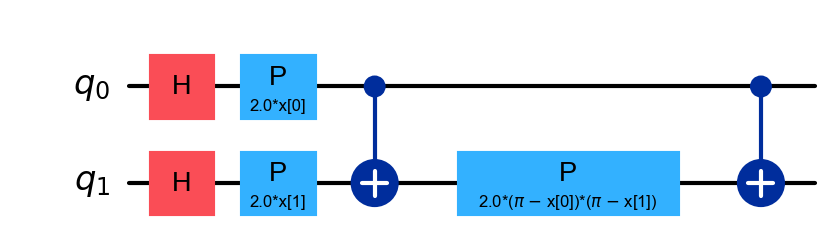

In [5]:
feature_map.decompose().draw('mpl',scale=1.5)

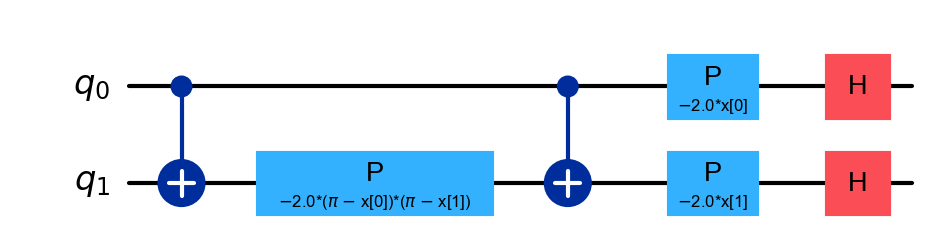

In [6]:
feature_map_dagger.decompose().draw('mpl',scale=1.5)

In [7]:
# Dataset 
data_input = [[1.5,1.4], \
          [1.5,1.00001], \
          [0.5, 0.8], \
          [0.99, 1.03],
          [1.2,0.8]]

# Initialize quantum circuit and ground state
num_qubits = 2


In [8]:
# For the practical implementation we can create compute overlap function similar to
# (https://github.com/Qiskit/qiskit-machine-learning/blob/main/qiskit_machine_learning/kernels/quantum_kernel.py)

def compute_overlap(idx, results, is_statevector_sim, measurement_basis):
        """
        Helper function to compute overlap for given input.
        """
        if is_statevector_sim:
            # |<0|Psi^dagger(y) x Psi(x)|0>|^2, take the amplitude
            v_a, v_b = [results.get_statevector(int(i)) for i in idx]
            tmp = np.vdot(v_a, v_b)
            kernel_value = np.vdot(tmp, tmp).real  # pylint: disable=no-member
        else:
            result = results.get_counts(idx)

            kernel_value = result.get(measurement_basis, 0) / sum(result.values())
        return kernel_value


In [9]:
backend = statevector_simulator

measurement_basis = "0" * num_qubits
circuits = [feature_map.assign_parameters(row) for row in data_input]
t_circuits = [transpile(circuit, backend) for circuit in circuits]
results = backend.run(t_circuits, run_options={
    'shots': 1024,
    'seed_transpiler': seed,
    'seed_simulator': seed}).result()

# Kernel matrix initialization
kernel_matrix_1_tamp_sv = np.identity(len(data_input))

for i_input in range(len(data_input)-1):
    for j_input in range(i_input+1,len(data_input),1):
        idx = list([i_input,j_input])
        fidelity = compute_overlap(idx,results,True,measurement_basis)
        kernel_matrix_1_tamp_sv[i_input,j_input] = fidelity
        kernel_matrix_1_tamp_sv[j_input,i_input] = fidelity

# Print the kernel matrix
print(kernel_matrix_1_tamp_sv)

[[1.         0.53222619 0.1997638  0.03925723 0.03588559]
 [0.53222619 1.         0.22828372 0.20341056 0.23425121]
 [0.1997638  0.22828372 1.         0.01521438 0.00272612]
 [0.03925723 0.20341056 0.01521438 1.         0.90682039]
 [0.03588559 0.23425121 0.00272612 0.90682039 1.        ]]


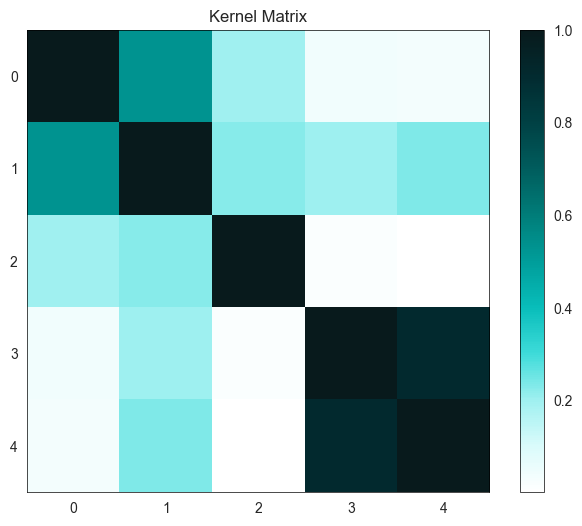

In [10]:
# Visualize kernel matrix
fig = plt.figure(figsize=(8,6))
plt.imshow(kernel_matrix_1_tamp_sv, \
           cmap='monochromatic_pos')
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()

In the previous calculations, we have used exact statevector values. Now, let’s estimate the fidelities based on distributions of measurements as produced by a QASM simulator. We expect to get close, but not exactly the same results. The QASM simulator approach replicates measurements on real hardware. (However, we are not going to use any noise models, which are out of scope for this module.)

In [11]:
# qasm simulator results
measurement_basis = "0" * num_qubits
circuits = []
experiment_map = dict() # dictionary to keep track of the mapping btw the experiment number and data columns
experiment_no = 0
for i_input in range(len(data_input)-1):
    for j_input in range(i_input+1,len(data_input),1):
        c1 = feature_map.assign_parameters(data_input[i_input])
        q = QuantumRegister(num_qubits, "q") # start with empty quantum register
        c = ClassicalRegister(num_qubits, "c") # start with empty classical register
        qc = QuantumCircuit(q, c)
        qc.append(c1.to_instruction(), qc.qubits)
        c2 = feature_map.assign_parameters(data_input[j_input])
        qc.append(c2.to_instruction().inverse(), qc.qubits)
        qc.measure(q, c)
        circuits.append(qc)
        experiment_map[experiment_no]=[i_input,j_input]
        experiment_no+=1


backend = qasm_simulator
t_circuits = [transpile(circuit, backend) for circuit in circuits]
results = backend.run(t_circuits, run_options={
     'shots': 8192,
     'seed_transpiler': seed,
     'seed_simulator': seed}).result()

# Kernel matrix initialization
kernel_matrix_2_tamp_qasm = np.identity(len(data_input))#

for i_experiment in range(len(circuits)):
        fidelity = compute_overlap(i_experiment,results,False,measurement_basis)
        i = experiment_map[i_experiment][0]
        j = experiment_map[i_experiment][1]
        kernel_matrix_2_tamp_qasm[i,j]=fidelity
        kernel_matrix_2_tamp_qasm[j,i]=fidelity

# Print the kernel matrix
print(kernel_matrix_2_tamp_qasm)

[[1.         0.53613281 0.20214844 0.03613281 0.03417969]
 [0.53613281 1.         0.25488281 0.21777344 0.23046875]
 [0.20214844 0.25488281 1.         0.01074219 0.        ]
 [0.03613281 0.21777344 0.01074219 1.         0.90625   ]
 [0.03417969 0.23046875 0.         0.90625    1.        ]]


The previous result deviates a little from statevector simulations. This is to be expected due to estimating the distribution based on a sample of measurements produced by the QASM simulator or hardware devices, even in the absence of noise.

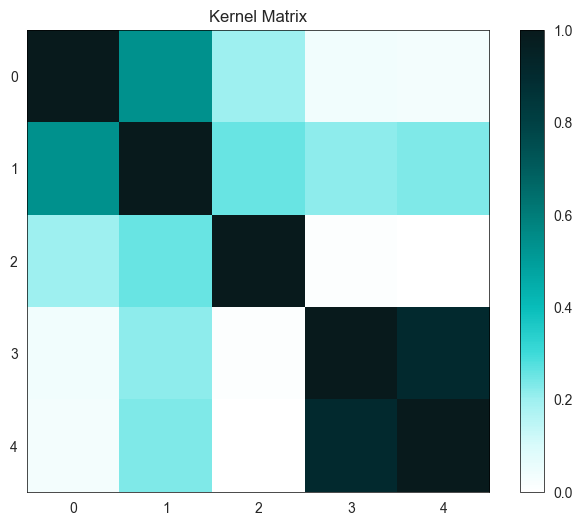

In [12]:
# Visualize kernel matrix
fig = plt.figure(figsize=(8,6))
plt.imshow(kernel_matrix_2_tamp_qasm, \
           cmap='monochromatic_pos')
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()

### `State_fidelity` function

In this section, we calculate the kernel matrix using the `state_fidelity` function implemented in `qiskit.quantum_info`.

Fidelity can be calculated by using the `state_fidelity` function. We compare the final state with the ground state. 

In [13]:
# Initialize ground state vector
ground_state = Statevector(np.concatenate(([1],[0]*(np.power(2,num_qubits)-1))))

# Table for intermediate results
summary_table = pd.DataFrame(columns=["Input_1","Input_2","Final State","Fidelity"])

# Kernel matrix initialization
kernel_matrix_3_tamp_stfid = np.identity(len(data_input))

In [14]:
backend = statevector_simulator

# Calculate fidelities and kernel matrix
def calculate_kernel_matrix1(data_input, ground_state, kernel_matrix, summary_table):
    for i_input in range(len(data_input)-1):
        for j_input in range(i_input+1,len(data_input),1):
            qc = QuantumCircuit.compose(feature_map.assign_parameters(data_input[i_input]), \
                                                                        feature_map_dagger.assign_parameters(data_input[j_input]))
            t_qc = transpile(qc, backend)
            result = backend.run(t_qc, run_options={
		        'shots': 8192,
                'seed_transpiler': seed,
                'seed_simulator': seed}).result()


            outputstate = result.get_statevector()
            fidelity = state_fidelity(outputstate,ground_state)
            kernel_matrix[i_input,j_input] = fidelity
            kernel_matrix[j_input,i_input] = fidelity
            summary_table.loc[-1] = np.array([data_input[i_input], \
                                     data_input[j_input], \
                                     np.asarray(outputstate), \
                                     fidelity],dtype="object")
            summary_table.index = summary_table.index + 1 
    
    summary_table = summary_table.sort_index()
    return kernel_matrix
         

kernel_matrix_3_tamp_stfid = calculate_kernel_matrix1(data_input, ground_state, kernel_matrix_3_tamp_stfid, summary_table)
summary_table

Input_1         Input_2  \
9      [1.5, 1.4]  [1.5, 1.00001]   
8      [1.5, 1.4]      [0.5, 0.8]   
7      [1.5, 1.4]    [0.99, 1.03]   
6      [1.5, 1.4]      [1.2, 0.8]   
5  [1.5, 1.00001]      [0.5, 0.8]   
4  [1.5, 1.00001]    [0.99, 1.03]   
3  [1.5, 1.00001]      [1.2, 0.8]   
2      [0.5, 0.8]    [0.99, 1.03]   
1      [0.5, 0.8]      [1.2, 0.8]   
0    [0.99, 1.03]      [1.2, 0.8]   

                                         Final State  Fidelity  
9  [(0.7056464585991413-0.18517360117639836j), (0...  0.532226  
8  [(0.1543144220409291+0.4194649699065123j), (0....  0.199764  
7  [(-0.1902691288178251-0.05527104642749445j), (...  0.039257  
6  [(-0.1821764219681581-0.05193593730139392j), (...  0.035886  
5  [(-0.12308181213666117+0.46166501709087315j), ...  0.228284  
4  [(0.39142226999783375-0.22405170186295825j), (...  0.203411  
3  [(0.3896387971969099-0.28711116754608146j), (0...  0.234251  
2  [(-0.12233506254186623+0.015764304197153745j),...  0.015214  
1  [(-0.03083147294872396-0.04213715672769591j), ...  0.002726  
0  [(0.9521331805054781+0.016211105490498062j), (...   0.90682

In [15]:
# Print the kernel matrix
print(kernel_matrix_3_tamp_stfid)

[[1.         0.53222619 0.1997638  0.03925723 0.03588559]
 [0.53222619 1.         0.22828372 0.20341056 0.23425121]
 [0.1997638  0.22828372 1.         0.01521438 0.00272612]
 [0.03925723 0.20341056 0.01521438 1.         0.90682039]
 [0.03588559 0.23425121 0.00272612 0.90682039 1.        ]]


The corresponding quantum circuit is as follows:

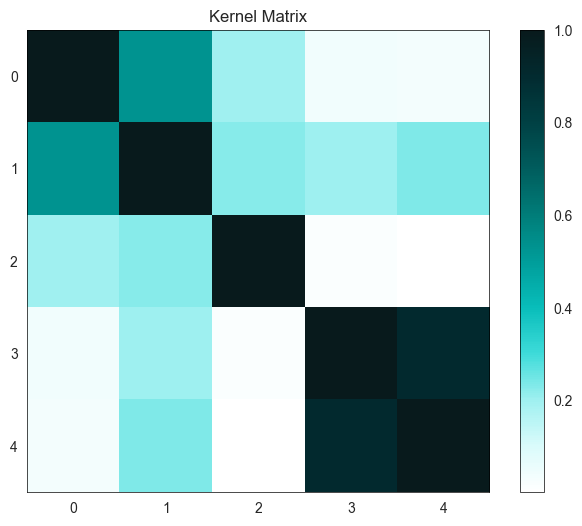

In [16]:
# Visualize kernel matrix
fig = plt.figure(figsize=(8,6))
plt.imshow(kernel_matrix_3_tamp_stfid, \
           cmap='monochromatic_pos')
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()

The circuit can be illustrated as follows:

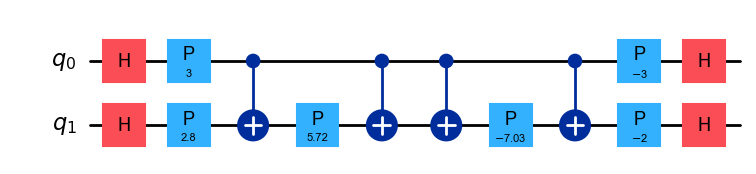

In [17]:
QuantumCircuit.compose(feature_map.assign_parameters(data_input[0]), \
                       feature_map_dagger.assign_parameters(data_input[1])) \
                       .decompose().draw('mpl', scale=1)
#plt.show()

## SWAP test

The SWAP test is another method used in quantum classifiers. The SWAP test uses quantum state fidelity as a measure of similarity, that is, $\vert\phi\rangle$ and $\vert\psi\rangle$ are identical or have an inner product of at most $\delta$.<sup>4</sup> $\vert\phi\rangle$ and $\vert\psi\rangle$ should have the same dimension, and the pairwise inner product of two feature vectors is bound below 1 in absolute value.<sup>5</sup> Using quantum state fidelity enables the use of a quantum feature map to the full extent. The quantum state fidelities between the training and test data are used as a distance measure.<sup>4</sup> 

### SWAP test technical details

The following gates are applied to the initial state to obtain the state fidelity by the SWAP test:

$$(H \otimes I) (c\textrm{-}SWAP)(H \otimes I) \vert0\rangle \vert\phi\rangle \vert\psi\rangle,$$
where $H$ is the Hadamard gate, $SWAP$ maps $\vert\phi\rangle$ $\vert\psi\rangle$ $\rightarrow$ $\vert\psi\rangle$ $\vert\phi\rangle$, and $c$-$SWAP$ is the controlled-$SWAP$ by the first qubit. Next, we will show that when measuring output 1, we find the probability $\frac{1}{2}- \frac{1}{2} {|\langle\phi\vert\psi\rangle|}^{2}$. <br>

$$(H \otimes I) (c\textrm{-}SWAP)(H \otimes I)\vert0\rangle \vert\phi\rangle \vert\psi\rangle$$
$$= \frac{1}{\sqrt{2}}(H \otimes I) (c\textrm{-}SWAP) (\vert0\rangle\vert\phi\rangle \vert\psi\rangle + \vert1\rangle\vert\phi\rangle\vert\psi\rangle)$$

Next, we will work out the $c\textrm{-}SWAP$. Recall that the $c$-$SWAP$ changes the order of the vectors only if the first qubit is 1. Therefore, we find the following expressions: <br>
$$= \frac{1}{\sqrt{2}}(H \otimes I) (\vert0\rangle\vert\phi\rangle \vert\psi\rangle + \vert1\rangle\vert\psi\rangle\vert\phi\rangle)$$

$$=\frac{1}{2}(\vert0\rangle\vert\phi\rangle \vert\psi\rangle + \vert1\rangle\vert\phi\rangle \vert\psi\rangle+ \vert0\rangle\vert\psi\rangle \vert\phi\rangle - \vert1\rangle\vert\psi\rangle \vert\phi\rangle)$$

<br>Factoring out $\vert0\rangle$ and $\vert1\rangle$ yields:<br>
$$= \frac{1}{2}\vert0\rangle(\vert\phi\rangle \vert\psi\rangle + \vert\psi\rangle \vert\phi\rangle)+ \frac{1}{2}\vert1\rangle(\vert\phi\rangle \vert\psi\rangle - \vert\psi\rangle \vert\phi\rangle).$$ 

<br>From this it follows that measuring $\vert1\rangle$ gives the probability of $\frac{1}{2}- \frac{1}{2}{|\langle\phi\vert\psi\rangle|}^{2}$. Note that the probability is 0 for two identical feature vectors and at least $\frac{1}{2}(1-\delta^2)>0$ if not.


### The circuit for the SWAP test

The SWAP test can be implemented by the following circuit. The entire circuit is implemented with ccx, controlled-NOT, $X$, and Hadamard gates. Hence, this module focuses on the implementation of the SWAP test circuit to obtain state fidelities and does not go into detail about data encoding. Data encoding and feature maps are discussed in a previous section. 


<img src="figs/SWAPtest.png" alt="drawing" width="600"/>

In [18]:
# Statevector simulator for SWAP test

num_qubits = 2

summary_table = pd.DataFrame(columns=["Input_1","Input_2","Fidelity"],dtype="object")


for i_input in range(len(data_input)-1):
    for j_input in range(i_input+1,len(data_input),1):

        swap_test_circuit = QuantumCircuit(2*num_qubits + 1,1) #create quantum circuit
        swap_test_circuit.compose(feature_map.assign_parameters(data_input[i_input]), \
                                  qubits=[1,2], inplace=True ) #asigns input 1 to 1st and 2nd qubits
        swap_test_circuit.compose(feature_map.assign_parameters(data_input[j_input]), \
                                  qubits=[3,4], inplace=True ) #asings input 2 to 3rd and 4th qubits
        swap_test_circuit.h(0) #applies hadarmard gate to 0th qubit

        # applies c-SWAP 
        for i in range(num_qubits):
            swap_test_circuit.cswap(0,i+1,i+1+num_qubits)

        swap_test_circuit.h(0) # applies hadamard gate on 0 qubit

        # Executes SWAP-test circuit
        t_swap_test_circuit = transpile(swap_test_circuit, backend)
        result = backend.run(t_swap_test_circuit, run_options={
            'shots': 8192,
            'seed_transpiler': seed,
            'seed_simulator': seed}).result()

        # Statevector
        result_Statevector = Statevector(result.get_statevector())
        q0_0=result_Statevector.probabilities([0])[0]

        # Fidelity
        fidelity = 2*(-0.5+q0_0)

        # Stores input, counts and fidelity outcome in summary table 2
        summary_table.loc[-1] = np.array([data_input[i_input], \
                                          data_input[j_input], \
                                          fidelity],dtype="object") 
        summary_table.index = summary_table.index + 1

summary_table

Input_1         Input_2  Fidelity
9      [1.5, 1.4]  [1.5, 1.00001]  0.532226
8      [1.5, 1.4]      [0.5, 0.8]  0.199764
7      [1.5, 1.4]    [0.99, 1.03]  0.039257
6      [1.5, 1.4]      [1.2, 0.8]  0.035886
5  [1.5, 1.00001]      [0.5, 0.8]  0.228284
4  [1.5, 1.00001]    [0.99, 1.03]  0.203411
3  [1.5, 1.00001]      [1.2, 0.8]  0.234251
2      [0.5, 0.8]    [0.99, 1.03]  0.015214
1      [0.5, 0.8]      [1.2, 0.8]  0.002726
0    [0.99, 1.03]      [1.2, 0.8]   0.90682

In [19]:
# kernel matrix SWAP test
kernel_matrix_4_swap_sv = np.identity(len(data_input))
i = 0
k = 0

# fill upper part digonal kernel matrix
for i_input in range(len(data_input)-1):
    for j_input in range(i_input+1,len(data_input),1):
        kernel_matrix_4_swap_sv[i_input][j_input] = summary_table.iloc[i,2]
        i= i+1

# fill lower part kernel matrix
for j_input in range(len(data_input)-1):
    for i_input in range(j_input+1,len(data_input),1):
        kernel_matrix_4_swap_sv[i_input][j_input] = summary_table.iloc[k,2]
        k= k+1
        
# Print the kernel matrix
print(kernel_matrix_4_swap_sv)

[[1.         0.53222619 0.1997638  0.03925723 0.03588559]
 [0.53222619 1.         0.22828372 0.20341056 0.23425121]
 [0.1997638  0.22828372 1.         0.01521438 0.00272612]
 [0.03925723 0.20341056 0.01521438 1.         0.90682039]
 [0.03588559 0.23425121 0.00272612 0.90682039 1.        ]]


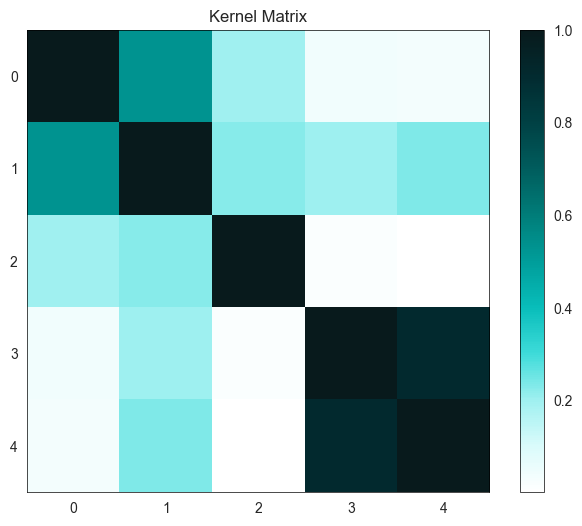

In [20]:
# Visualize kernel matrix
fig = plt.figure(figsize=(8,6))
plt.imshow(kernel_matrix_4_swap_sv, \
          cmap='monochromatic_pos')
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()

In [21]:
# Implement SWAP-test circuit applied on all inputs - QASM simulator
num_qubits = 2

summary_table = pd.DataFrame(columns=["Input_1","Input_2","Counts", "Fidelity"], \
                             dtype="object")


backend = qasm_simulator

for i_input in range(len(data_input)-1):
    for j_input in range(i_input+1,len(data_input),1):

        swap_test_circuit = QuantumCircuit(2*num_qubits + 1,1) #create quantum circuit
        swap_test_circuit.compose(feature_map.assign_parameters(data_input[i_input]), \
                                  qubits=[1,2], inplace=True ) #asigns input 1 to 1st and 2nd qubits
        swap_test_circuit.compose(feature_map.assign_parameters(data_input[j_input]), \
                                  qubits=[3,4], inplace=True ) #asings input 2 to 3rd and 4th qubits
        swap_test_circuit.h(0) #applies hadarmard gate to 0th qubit

        # applies c-SWAP 
        for i in range(num_qubits):
            swap_test_circuit.cswap(0,i+1,i+1+num_qubits)
            
        swap_test_circuit.h(0) # applies hadamard gate on 0 qubit
        swap_test_circuit.measure([0],[0]) # measures 0 qubit

        # Executes SWAP-test circuit
        t_swap_test_circuit = transpile(swap_test_circuit, backend)
        result = backend.run(t_swap_test_circuit, run_options={
            'shots': 8192,
            'seed_transpiler': seed,
            'seed_simulator': seed}).result()

        # Counts measured states of 0th qubit, i.e. |0> or |1>
        counts = result.get_counts()

        # Fidelity
        fidelity = 2*(-0.5+counts['0']/(counts['0']+counts['1']))

        # Stores input, counts and fidelity outcome in summary table 2
        summary_table.loc[-1] = np.array([data_input[i_input],data_input[j_input], \
                                          counts,fidelity],dtype="object")
        summary_table.index = summary_table.index + 1

summary_table

Input_1         Input_2                Counts  Fidelity
9      [1.5, 1.4]  [1.5, 1.00001]  {'1': 231, '0': 793}  0.548828
8      [1.5, 1.4]      [0.5, 0.8]  {'1': 406, '0': 618}  0.207031
7      [1.5, 1.4]    [0.99, 1.03]  {'1': 489, '0': 535}  0.044922
6      [1.5, 1.4]      [1.2, 0.8]  {'1': 483, '0': 541}  0.056641
5  [1.5, 1.00001]      [0.5, 0.8]  {'1': 391, '0': 633}  0.236328
4  [1.5, 1.00001]    [0.99, 1.03]  {'0': 611, '1': 413}  0.193359
3  [1.5, 1.00001]      [1.2, 0.8]  {'0': 643, '1': 381}  0.255859
2      [0.5, 0.8]    [0.99, 1.03]  {'1': 496, '0': 528}   0.03125
1      [0.5, 0.8]      [1.2, 0.8]  {'0': 523, '1': 501}  0.021484
0    [0.99, 1.03]      [1.2, 0.8]   {'1': 41, '0': 983}  0.919922

In [22]:
# kernel matrix SWAP test
kernel_matrix_5_swap_qasm = np.identity(len(data_input))
i = 0
k = 0

# fill upper part digonal kernel matrix
for i_input in range(len(data_input)-1):
    for j_input in range(i_input+1,len(data_input),1):
        kernel_matrix_5_swap_qasm[i_input][j_input] = summary_table.iloc[i,3]
        i= i+1

# fill lower part kernel matrix
for j_input in range(len(data_input)-1):
    for i_input in range(j_input+1,len(data_input),1):
        kernel_matrix_5_swap_qasm[i_input][j_input] = summary_table.iloc[k,3]
        k= k+1
        
# Print the kernel matrix
print(kernel_matrix_5_swap_qasm)

[[1.         0.54882812 0.20703125 0.04492188 0.05664062]
 [0.54882812 1.         0.23632812 0.19335938 0.25585938]
 [0.20703125 0.23632812 1.         0.03125    0.02148438]
 [0.04492188 0.19335938 0.03125    1.         0.91992188]
 [0.05664062 0.25585938 0.02148438 0.91992188 1.        ]]


The following is an illustration of the SWAP test circuit:

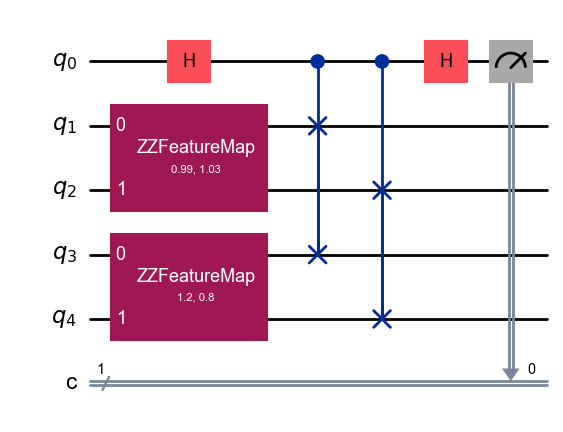

In [23]:
swap_test_circuit.draw('mpl', scale=1) #Draws quantum circuit SWAP-test
#plt.show()

### Decomposition and circuit depth

The SWAP test circuit uses two Toffoli gates. Hence, a Toffoli gate can be further decomposed to one- and two-qubit gates with controlled-NOT gates. The following circuit shows the decomposed SWAP test circuit. Hence, this circuit reveals the complexity of the SWAP test. The circuit depth of the SWAP test scales linearly with the amount of qubits used; see the following figure. 

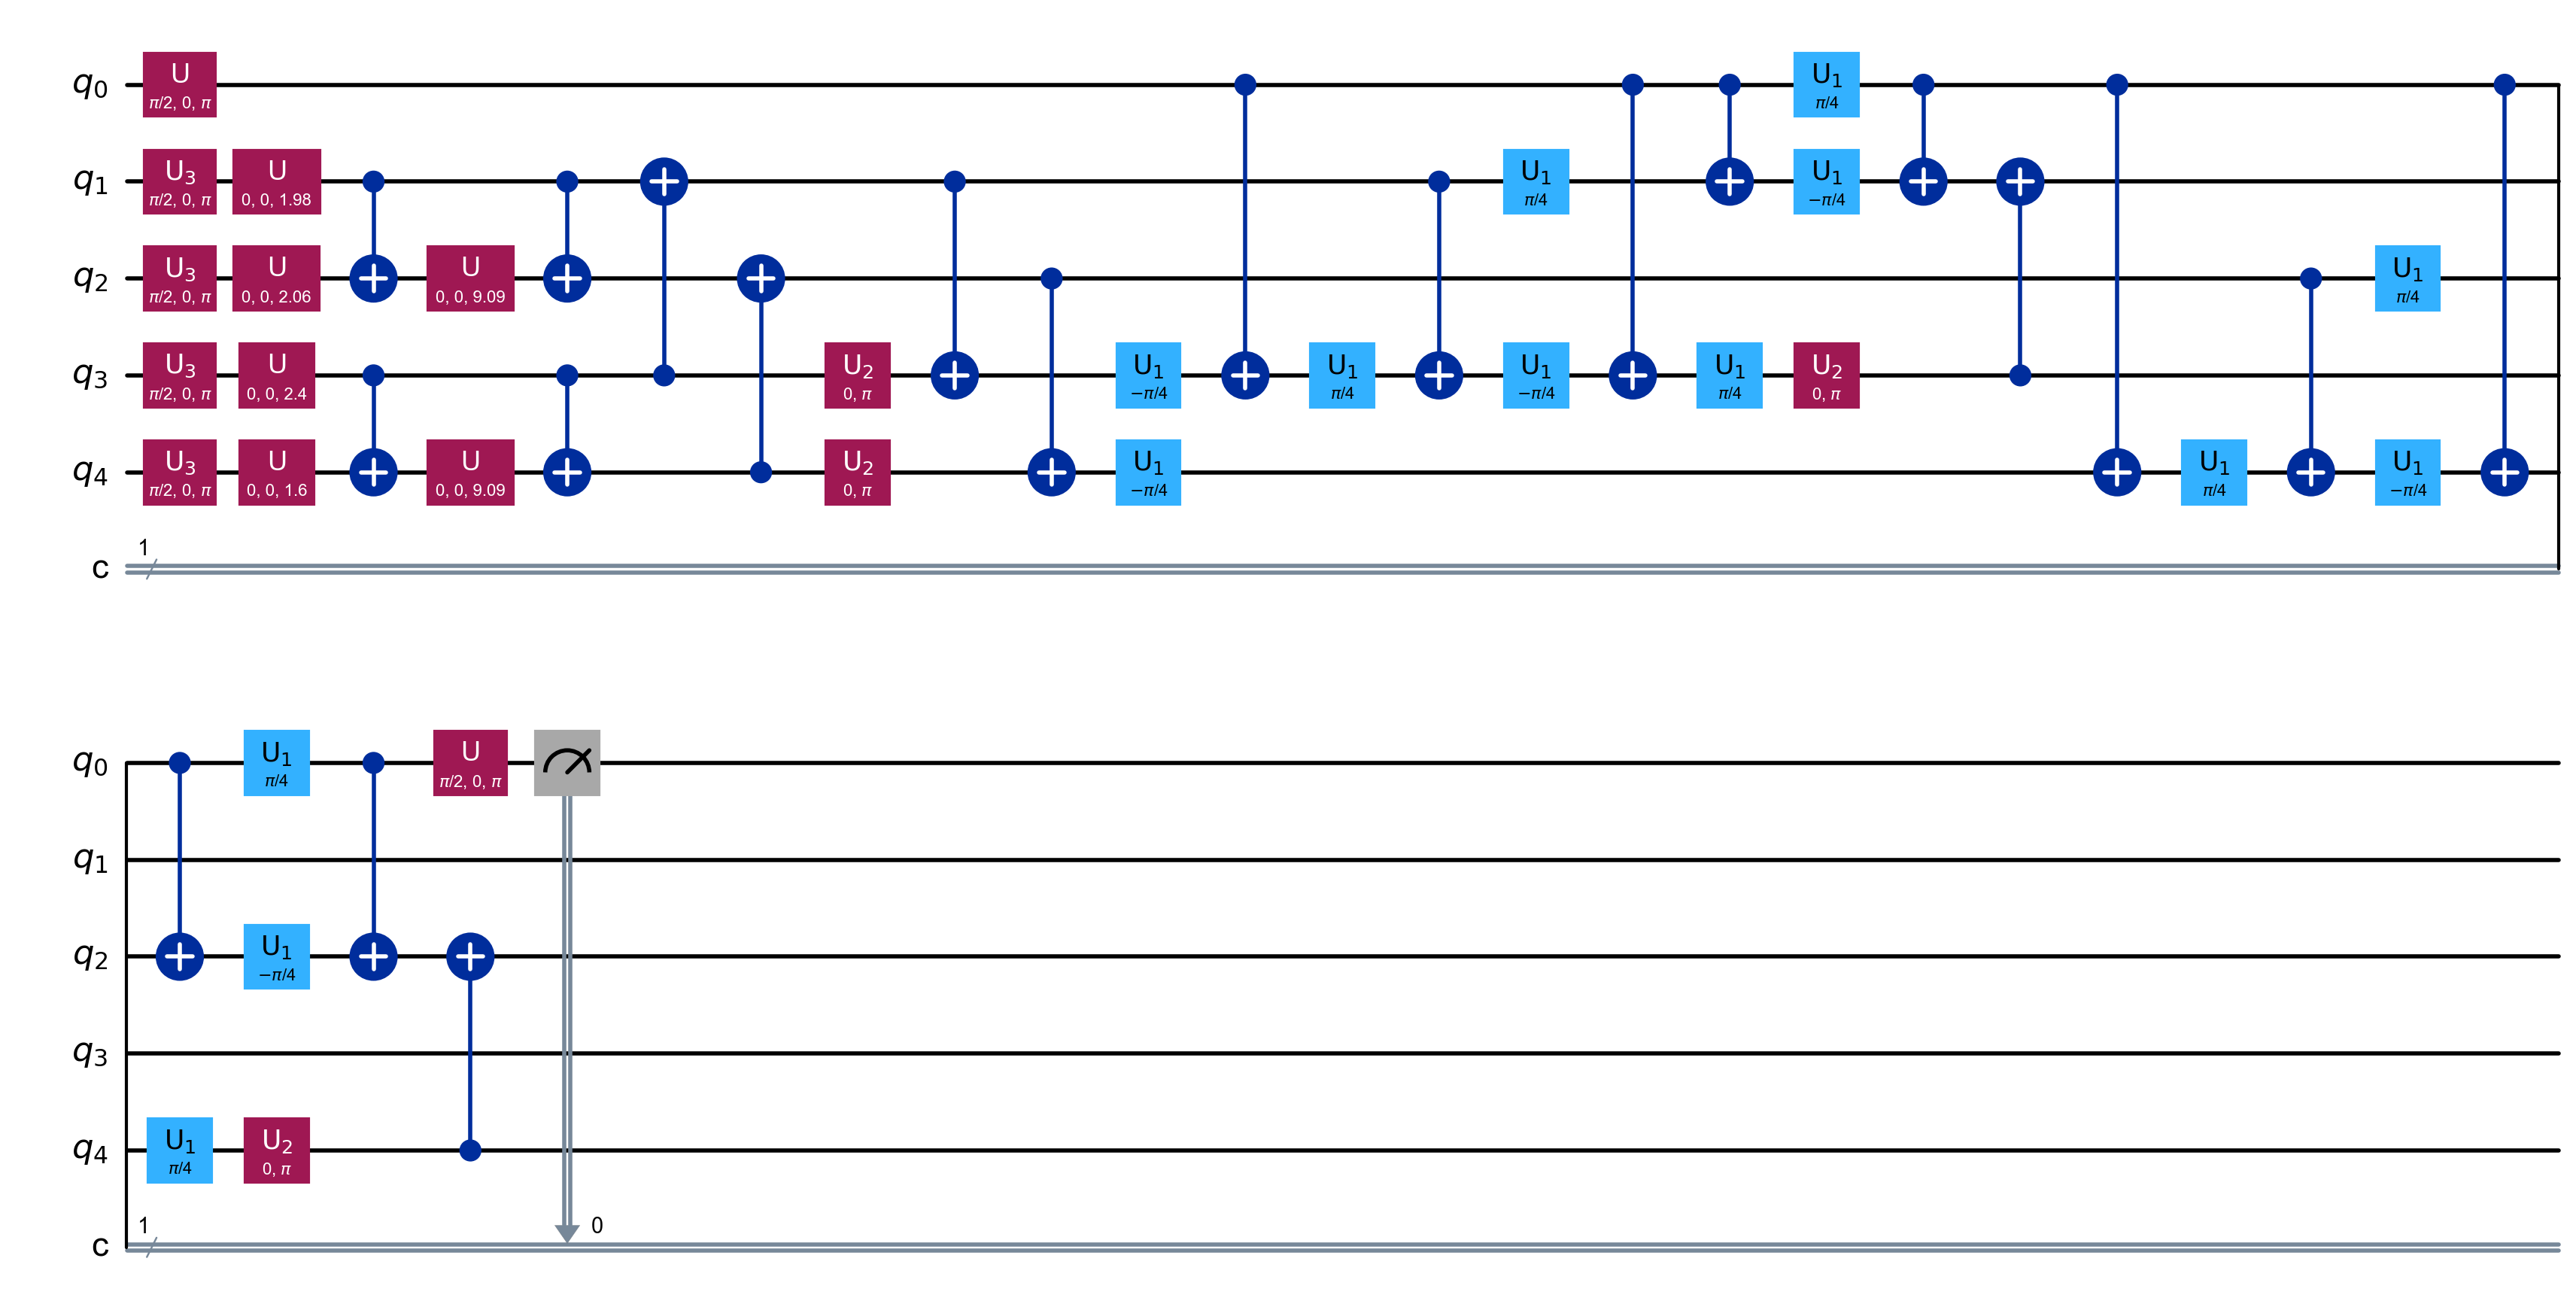

In [24]:
swap_test_circuit.decompose().decompose().decompose().draw('mpl', scale=2) 
#plt.show()

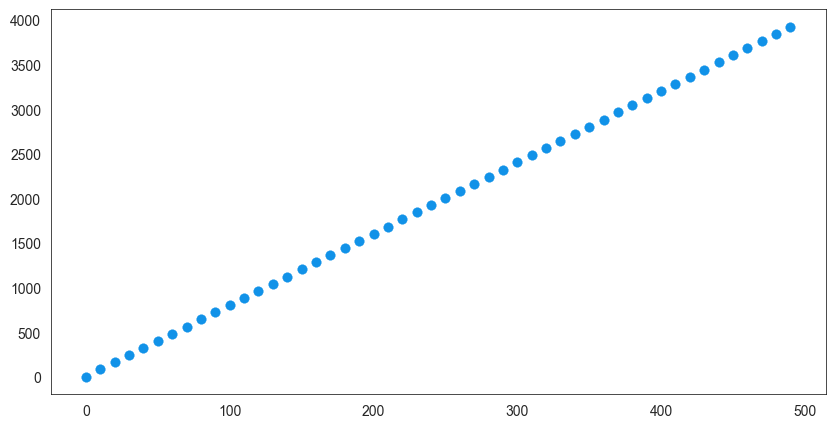

In [25]:
# SWAP Test circuit depth
def getSWAPtestCircuitDepth(num_qubits = 2):

    swap_test_circuit = QuantumCircuit(2*num_qubits + 1,1)
    swap_test_circuit.h(0)
    for i in range(num_qubits):
        swap_test_circuit.cswap(0,i+1,i+1+num_qubits)
    swap_test_circuit.h(0)
    swap_test_circuit.measure([0],[0])
    return swap_test_circuit.decompose().decompose().decompose().depth()

x_qubits = list(range(0,500,10))
y_depths = [getSWAPtestCircuitDepth(num_q) for num_q in x_qubits]
plt.figure(figsize=(10,5))
plt.scatter(x_qubits,y_depths)
plt.show()

The circuit depth grows linearly with the number of input qubits. Large circuit depth is the major downside of using the SWAP test for fidelity estimations.

## `QuantumKernel` function

Now, let’s calculate the kernel matrix with the `FidelityQuantumKernel` function in the `qiskit_machine_learning` library.

In [26]:
#calculate quantum kernel
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
qk = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

kernel_matrix_6_qk = qk.evaluate(data_input)

In [27]:
# Print the kernel matrix
print(kernel_matrix_6_qk)

[[1.         0.53222619 0.1997638  0.03925723 0.03588559]
 [0.53222619 1.         0.22828372 0.20341056 0.23425121]
 [0.1997638  0.22828372 1.         0.01521438 0.00272612]
 [0.03925723 0.20341056 0.01521438 1.         0.90682039]
 [0.03588559 0.23425121 0.00272612 0.90682039 1.        ]]


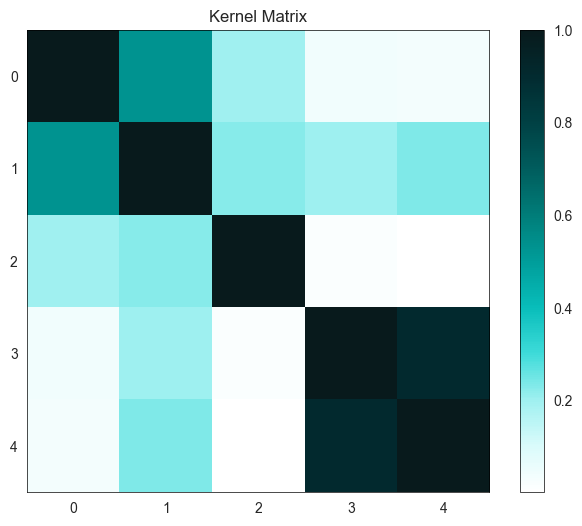

In [28]:
# Visualize kernel matrix
fig = plt.figure(figsize=(8,6))
plt.imshow(kernel_matrix_6_qk, \
          cmap='monochromatic_pos')
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()

## Comparison of quantum kernels calculated with different approaches

Let’s print out all of the kernel matrices we have computed so far:

In [29]:
print("Kernel Matrix - transition amplitude {statevector, qasm, state_fidelity function}")
print(kernel_matrix_1_tamp_sv)
print(kernel_matrix_2_tamp_qasm)
print(kernel_matrix_3_tamp_stfid)
print("\n\nKernel Matrix - SWAP test {statevector, qasm}")
print(kernel_matrix_4_swap_sv)
print(kernel_matrix_5_swap_qasm)
print("\n\nKernel Matrix - FidelityQuantumKernel function")
print(kernel_matrix_6_qk)

Kernel Matrix - transition amplitude {statevector, qasm, state_fidelity function}
[[1.         0.53222619 0.1997638  0.03925723 0.03588559]
 [0.53222619 1.         0.22828372 0.20341056 0.23425121]
 [0.1997638  0.22828372 1.         0.01521438 0.00272612]
 [0.03925723 0.20341056 0.01521438 1.         0.90682039]
 [0.03588559 0.23425121 0.00272612 0.90682039 1.        ]]
[[1.         0.53613281 0.20214844 0.03613281 0.03417969]
 [0.53613281 1.         0.25488281 0.21777344 0.23046875]
 [0.20214844 0.25488281 1.         0.01074219 0.        ]
 [0.03613281 0.21777344 0.01074219 1.         0.90625   ]
 [0.03417969 0.23046875 0.         0.90625    1.        ]]
[[1.         0.53222619 0.1997638  0.03925723 0.03588559]
 [0.53222619 1.         0.22828372 0.20341056 0.23425121]
 [0.1997638  0.22828372 1.         0.01521438 0.00272612]
 [0.03925723 0.20341056 0.01521438 1.         0.90682039]
 [0.03588559 0.23425121 0.00272612 0.90682039 1.        ]]


Kernel Matrix - SWAP test {statevector, qas

Notice that `Kernel Matrix - transition amplitude {statevector, state_fidelity function}` and `Kernel Matrix - FidelityQuantumKernel function` are the same. Regardless of whether we calculate the transition amplitude directly or use a SWAP test, we get exactly the same result as long as we use the statevector simulator. However, the results from a QASM simulator are different.

## Sampling (shot) noise

As we have seen, the QASM simulator results differ from the exact statevector calculations. This is due to finite sampling noise (note: we didn’t include any hardware noise) that already impacts the kernel matrix estimate. In the following section of code, we are calculating the difference between $K$ and ${K}^{\prime}$, where $K$ is ideal and ${K}^{\prime}$ has shot sampling noise. We also calculate the elementwise norm ${\lVert{K-{K}^{\prime}}\rVert}_{2}$.

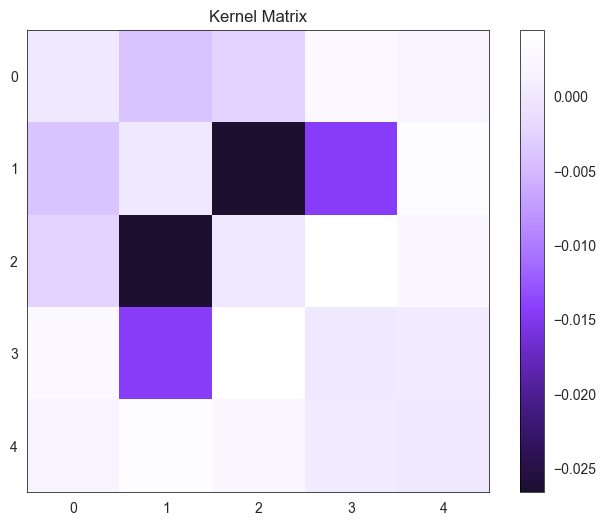

[[ 0.         -0.00390663 -0.00238464  0.00312442  0.0017059 ]
 [-0.00390663  0.         -0.02659909 -0.01436288  0.00378246]
 [-0.00238464 -0.02659909  0.          0.00447219  0.00272612]
 [ 0.00312442 -0.01436288  0.00447219  0.          0.00057039]
 [ 0.0017059   0.00378246  0.00272612  0.00057039  0.        ]]
[[1.5, 1.4], [1.5, 1.00001], [0.5, 0.8], [0.99, 1.03], [1.2, 0.8]]


In [30]:
# Comparison btw kernel matrices estimated with transition amplitudes using statevector and qasm simulators
diff_kernel_matrics = kernel_matrix_1_tamp_sv - kernel_matrix_2_tamp_qasm 

fig = plt.figure(figsize=(8,6))
plt.imshow(diff_kernel_matrics, \
          cmap='monochromatic_neg') # different color coding to highlight comparison
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()
print(diff_kernel_matrics)
print(data_input)

In [31]:
np.linalg.norm((kernel_matrix_1_tamp_sv - kernel_matrix_2_tamp_qasm),'fro')

0.04448570367915152

In [32]:
np.linalg.norm((kernel_matrix_1_tamp_sv - kernel_matrix_5_swap_qasm),'fro')

0.06640200570512012

Increasing the number of shots will help to decrease this sampling noise. Currently, sampling noise with thousands of shots represents only a fraction of other hardware-related noise channels.

## Quantum kernel calculation for a custom feature map

In the “Feature Maps and Variational Circuits” unit, we built the following custom feature map:

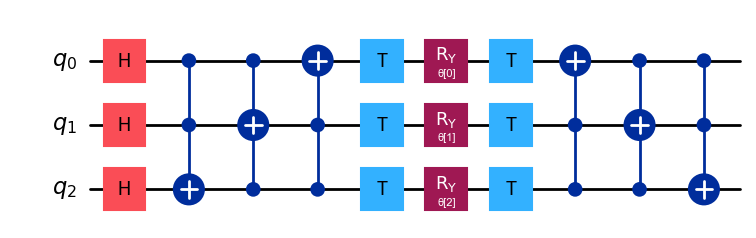

In [33]:
qc = QuantumCircuit(3)
pvec = ParameterVector('θ',3)

qc.h(range(3))    
qc.ccx(0,1,2)
qc.ccx(2,0,1)
qc.ccx(2,1,0)
qc.t(range(3))
for i,i_param in enumerate(pvec):
    qc.ry(i_param, i)
qc.t(range(3))
qc.ccx(2,1,0)
qc.ccx(2,0,1)
qc.ccx(0,1,2)

qc.draw('mpl')
#plt.show()

This custom feature map can be used to calculate the quantum kernel directly:

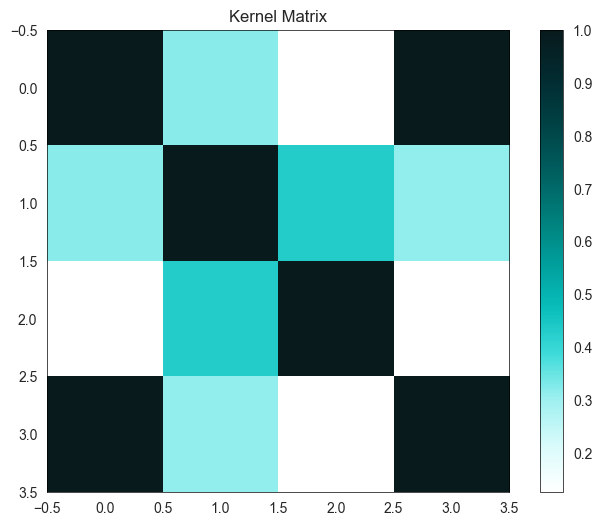

In [34]:
# Now we can simulate the input data
X = [[1,2,3],[0.1,0.2,0.1],[4,5,6],[1.1,2,3]]

# Calculate quantum kernel
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
qk = FidelityQuantumKernel(fidelity=fidelity, feature_map=qc)

kernel_matrix = qk.evaluate(X)

# Visualize quantum kernel
fig = plt.figure(figsize=(8,6))
plt.imshow(np.asmatrix(kernel_matrix), \
          cmap='monochromatic_pos')
plt.title("Kernel Matrix")
plt.colorbar()
plt.show()

The kernel matrix above shows that our custom feature map is sensitive to relative distances between our input data points defined in 3D.

## Conclusion

In this notebook, we have calculated the kernel matrix using transition amplitude and SWAP test approaches, leveraging low-level implementations and high-level Qiskit library functions. We have demonstrated the use of statevector and QASM simulators. All of the approaches yielded similar results. From the practical implementation standpoint, transition amplitude seems to be the preferred method, as it has shallower circuits compared to the SWAP test. However, either approach requires $\mathcal O({\vert T \vert}^{2})$ amplitude estimations, where $\vert T \vert$ is the size of the input data.


## References
1. <a id='Hofmann2008'></a>Thomas Hofmann, Bernhard Schölkopf, and Alexander J. Smola. “Kernel Methods in Machine Learning.” *Annals of Statistics*, vol. 36, no. 3 (2008): 1171–1220. https://arxiv.org/abs/math/0701907.

2. <a id='Schuld2021'></a>Maria Schuld. “Supervised Quantum Machine Learning Models Are Kernel Methods.” arXiv:2101.11020, last updated April 17, 2021. https://arxiv.org/abs/2101.11020.

3. <a id='Havlicek2019'></a>Vojtech Havlicek et al. “Supervised Learning with Quantum Enhanced Feature Spaces.” *Nature*, vol. 567 (2019): 209–212. https://arxiv.org/abs/1804.11326.

4. <a id='Blank2020'></a>Carsten Blank et al. “Quantum Classifier with Tailored Quantum Kernel.” *npj Quantum Information*, vol. 6, no. 41 (2020). https://www.nature.com/articles/s41534-020-0272-6.

5. <a id='Buhrman2001'></a>Harry Buhrman et al. “Quantum Fingerprinting.” *Physical Review Letters*, vol. 87 (2001). https://arxiv.org/abs/quant-ph/0102001.

6. <a id='Cincio2018'></a>Lukasz Cincio et al. “Learning the Quantum Algorithm for State Overlap.” *New Journal of Physics*, vol. 20 (2018). https://arxiv.org/abs/1803.04114.

7. <a id='ChuangNielsen2000'></a>Michael A. Nielsen and Isaac L. Chuang. *Quantum Computation and Quantum Information*, 10th ed. Cambridge, UK: Cambridge University Press, 2000.

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>